# RED NEURONAL.
El objetivo de este trabajo es armar una red neuronal que pueda predecir la siguiente nota. Se elaboraron tres modelos, el basico donde se trabajo primeramente, el siguiente modelo armado con la funcion de activacion softmax y el modelo armado con tensorflow que sirvio de control.

La base de datos elegida es un conjunto de datos que contiene alrededor de 200hs de grabaciones de audio y MIDI emparejadas de diez años de Concurso Internacional de Piano.

FUENTE: https://magenta.tensorflow.org/datasets/maestro

- Aclaracion: Este modelo fue el siguiente, donde se plantea el uso de la funcion de activacion softmax para la capa de salida.

In [ ]:
# import zipfile as zf
# files = zf.ZipFile("/content/maestro-v3.0.0-midi.zip", 'r')
# files.extractall('data/')
# files.close()
!pip install pretty_midi
!pip install tensorflow
!pip install scikit-learn

Se instalan todos los paquetes relevantes para procesar y escuchar archivos MIDI, glob para iterar sobre los archivos del dataset, collections para el diccionario con valor por defecto, y pathlib para abrir el archivo.

In [ ]:
import collections
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import tensorflow as tf
import itertools
from sklearn.model_selection import train_test_split

Se define un directorio que contendra todos los archivos MIDI que seran analizados. Se arma una funcion que convierte esos archivos a un DataFrame de pandas donde utilizamos una variable para definir una "nota" que contendra como caracteristica el tono (pitch). Tono es la calidad sonora de la nota, lo que la distingue de otras.

In [ ]:
np.random.seed(10)

In [ ]:
directorio = pathlib.Path('data/maestro-v2.0.0')
if not directorio.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

filenames = glob.glob(str(directorio/'**/*.mid*'))
print('num archivos:', len(filenames))

# sample_file = "/content/MIDI-Unprocessed_25_R2_2011_MID--AUDIO_R2-D6_07_Track07_wav.midi"
# print(sample_file)

def midi_a_notas(midifile: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midifile)
    instrumento = pm.instruments[0]
    notas = collections.defaultdict(list)

    notas_orden = sorted(instrumento.notes, key=lambda nota: nota.start)
    previa_inicio = notas_orden[0].start

    for nota in notas_orden:
        notas['pitch'].append(nota.pitch)

    return pd.DataFrame({nombre: np.array(valor) for nombre, valor in notas.items()})

59243107/59243107 [==============================] - 1s 0us/step
num archivos: 1282


Se agrega un fragmento de codigo hecho por otra persona, que permite escribir un dataframe con notas en un archivo midi y lo devuelve como prettyMIDI para poder escucharlo (No se usa):

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

Se procesan los archivos MIDI, se extraen las notas de cada archivo y se preparan los datos para el modelo del aprendizaje automatico mas adelante.

In [ ]:
notasGlobal = []
tam_muestra = 20

for f in filenames[:tam_muestra]:
  notas = midi_a_notas(f)
  notasGlobal.append(notas)

notasGlobal = pd.concat(notasGlobal)
print(notasGlobal.head())

indice_notas = ['pitch']
notas_entrenamiento = np.array([notasGlobal[key] for key in indice_notas]).flatten()
np.set_printoptions(precision=3)
dataset_nota = tf.data.Dataset.from_tensor_slices(notas_entrenamiento)
print(notas_entrenamiento)
#print(list(dataset_nota.as_numpy_iterator()))

   pitch
0     68
1     63
2     75
3     72
4     60
[68 63 75 ... 46 43 39]


Luego, transformamos el dataset de las notas en ventanas de secuencias para su uso.

In [ ]:
def ventanizar(dataset, tam_ventana, alfabeto_notas = 128,) -> tf.data.Dataset:
  tam_ventana = tam_ventana + 1

  windows = dataset.window(tam_ventana, shift=1, stride=1, drop_remainder=True)
  flatten = lambda x: x.batch(tam_ventana, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize tono de las notas
  def normalizar_tono(x):
    x = x/tam_ventana
    return x

  # Partimos los indices
  def partir_indices(sequences):
    inputs = sequences[:-1]
    outputs_dense = sequences[-1]
    return normalizar_tono(inputs), outputs_dense
  return sequences.map(partir_indices,num_parallel_calls=tf.data.AUTOTUNE)

ventanitas = ventanizar(dataset_nota, 100)
dataset_pandas = pd.DataFrame(list(ventanitas.as_numpy_iterator()), columns=['inputs','output'])
dataset_pandas['output'].head()

0    67
1    63
2    67
3    62
4    72
Name: output, dtype: int64

Convertimos el output a formato one-hot, convirtiendo cada indice a un formato binario de 128 caracteres, donde el unico "1" es el que corresponde a dicho indice
Ej: [0,1,2,3,4] = [[1,0,0,0,0],
                   [0,1,0,0,0],
                   [0,0,1,0,0],
                   [0,0,0,1,0],
                   [0,0,0,0,1]]

In [ ]:
def onehotizar(valor):
  lista = [0 for x in range(128)]
  lista[valor-1] = 1
  return lista

dataset_pandas['output'] = dataset_pandas['output'].map(onehotizar)


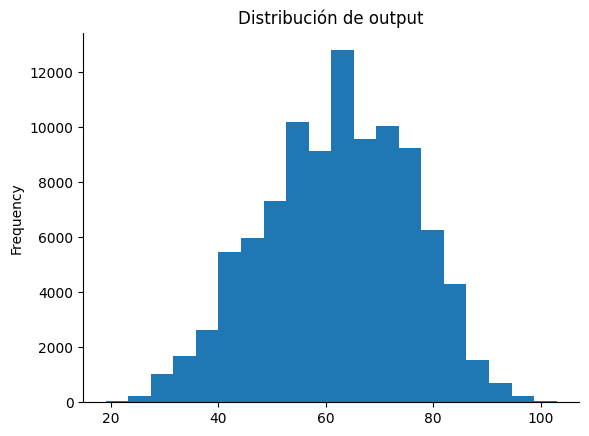

In [ ]:

from matplotlib import pyplot as plt
(dataset_pandas['output'].map(np.argmax)-1).plot(kind='hist', bins=20, title='Distribución de output')
plt.gca().spines[['top', 'right',]].set_visible(False)

Preparacion de los datos para trabajar con la red. Se separa el split de la base de datos de la red propiamente dicha para que se entrene la red siempre con los mismos datos.

In [ ]:
# neuronas_entrada = 100 / neuronas_de_la_capa_oculta = 60 / neurona_salida = 1

# Extraemos los datos de entrada y de salida
inputs = np.array(dataset_pandas['inputs'].tolist())
output = np.array(dataset_pandas['output'].tolist())


# Separar un conjunto de datos para entrenar y otro para probar
x_train, x_test, y_train, y_test = train_test_split(inputs, output, test_size=1/3)

In [ ]:
x_train

array([[0.881, 0.762, 0.475, ..., 0.525, 0.554, 0.832],
       [0.812, 0.822, 0.842, ..., 0.465, 0.416, 0.465],
       [0.426, 0.594, 0.475, ..., 0.475, 0.465, 0.743],
       ...,
       [0.515, 0.436, 0.446, ..., 0.515, 0.505, 0.743],
       [0.505, 0.584, 0.743, ..., 0.673, 0.743, 0.574],
       [0.604, 0.693, 0.347, ..., 0.663, 0.921, 0.584]])

In [ ]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Se inicializan las variables y se definen las funciones para el entrenamiento de la red. Se deja todo optimo para entrenar la red.

In [ ]:
# Pesos y sesgos
w_hidden = np.random.rand(110, 100) * 2 - 1
w_output = np.random.rand(128, 110) * 2 - 1
b_hidden = np.random.rand(110, 1) * 2 - 1
b_output = np.random.rand(128, 1) * 2 - 1

# Funcion de activacion y la derivada
def softmax(x):
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

def d_softmax(x):
    Sx = softmax(x)
    D = -np.outer(Sx, Sx) + np.diag(Sx.flatten())
    return D

def xent(pred, y):
    assert(pred.shape == y.shape)
    return -np.sum(y * np.log(pred + 10**-100))

def d_xent(y, pred):
    return -y/(pred + 10**-100)

relu = lambda x: np.where(x > 0, x, 0.01 * x)
d_relu = lambda x: np.where(x > 0, 1, 0.01)

# Forward Propagation, recorrer la red hacia adelante
def forward_prop(x):
	z1 = np.matmul(w_hidden, x).reshape((110,1)) + b_hidden
	a1 = relu(z1)
	z2 = np.matmul(w_output, a1) + b_output
	a2 = softmax(z2)
	return z1, a1, z2, a2

# Backpropagation, recorrer la red hacia atras
def backward_prop(z1, a1, z2, a2, x, y):

  error_upto_softmax = np.sum(d_xent(y, a2) * d_softmax(z2), axis = 0).reshape((-1, 1))
  error_upto_hidden = np.sum(error_upto_softmax * w_output, axis = 0).reshape((-1, 1))
  error_upto_relu = error_upto_hidden * d_relu(z1)

  dc_dw2 = error_upto_softmax.dot( a1.T )
  dc_db2 = error_upto_softmax
  dc_dw1 = error_upto_relu.dot( x.T )
  dc_db1 = error_upto_relu

  return dc_dw1, dc_db1, dc_dw2, dc_db2

Se define el calculo de precision para el test y el train. Tambien se calcula el accuracy antes de entrenar la red.

In [ ]:
# Calculo de precision, calculo muchas precisiones individuales y las promedio.
def calcular_accuracy():
  accuracy_train = 0
  accuracy_test = 0
  np.set_printoptions(precision=5, suppress=False)
  iters = 2500
  for i in range(iters):
    idx = np.random.randint(0, len(x_test))
    test_predictions = np.argmax(forward_prop(x_test[idx].T)[3])+1
    accuracy_individual_test =  np.argmax(y_test[idx])+1 == test_predictions
    accuracy_test += accuracy_individual_test

    jdx = np.random.randint(0, len(x_train))
    train_predictions = np.argmax(forward_prop(x_train[jdx].T)[3])+1
    accuracy_individual_train =  np.argmax(y_train[jdx])+1 == train_predictions
    accuracy_train += accuracy_individual_train

  return accuracy_test, accuracy_train, iters

# Se muestra el valor del accuracy antes del entrenamiento
valor_test, valor_train, intentos = calcular_accuracy()

Se arma la funcion que grafica los valores de loss (diferencia entre valor real y obtenido)

In [ ]:
def graficar_loss(L, train_l, test_l):
    #print(train_l)
    #print(test_l)
    iters = len(test_l)
    fmt_train = {
        'color': 'tab:blue',
        'ls': 'solid',
        'lw': 3,
    }
    fmt_test = {
        'color': 'tab:orange',
        'ls': 'solid',
        'lw': 3,
    }

    fig, (ax) = plt.subplots(1, 1, figsize = (10, 8))

    ax.plot(train_l, label = 'Train', **fmt_train)
    ax.plot(test_l, label = 'Test', **fmt_test)

    ax.grid(which='both')
    ax.legend()
    ax.set_title(f'Loss {L=}')
    ax.set_xlabel(f'Iters {iters=}')
    ax.set_ylabel('Loss')

    fig.tight_layout()
    plt.savefig(f'accuracy_{L=}_{iters=}.png')

Se arma la funcion que calcula el loss utilizando entropía cruzada


In [ ]:
def calcular_loss():
  loss_train = 0
  loss_test = 0
  np.set_printoptions(precision=5, suppress=False)
  iters = 2500
  for i in range(iters):
    idx = np.random.randint(0, len(x_test))
    test_predictions = forward_prop(x_test[idx].T)[3]
    loss_individual_test =  xent(test_predictions, y_test[idx].reshape(128,1))
    loss_test += loss_individual_test

    jdx = np.random.randint(0, len(x_train))
    train_predictions = forward_prop(x_train[jdx].T)[3]
    loss_individual_train =  xent(train_predictions, y_train[jdx].reshape(128,1))
    loss_train += loss_individual_train

  return loss_test/iters, loss_train/iters



Se muestra el valor del accuracy y loss antes del entrenamiento.

In [ ]:
print(f'Loss test: {calcular_loss()[0]}')
print(f'Loss train: {calcular_loss()[1]}')
print(f'Accuracy Test = {round((calcular_accuracy()[0]/calcular_accuracy()[2]*100),3)}%')
print(f'Accuracy Train = {round((calcular_accuracy()[1]/calcular_accuracy()[2]*100),3)}%')

Loss test: 52.4400049403227
Loss train: 51.998854203414226
Accuracy Test = 1.4%
Accuracy Train = 1.44%


Se define una funcion que contiene el entrenamiento de la red neuronal para asi encontrar los valores mas optimos para la misma. La red ya esta definida para la utilizacion de todas las variables y funciones declaradas anteriormente.

In [ ]:
def red_neuronal (L, epoch, momentum, w_hidden, w_output, b_hidden, b_output,update_w1,update_b1,update_w2,update_b2):

  loss_test_l = []
  loss_train_l = []
  # Ejecutar descenso de gradiente con inercia
  for i in range(epoch):
    # Seleccion aleatoria de unos de los datos de entrenamiento
    idx = [np.random.randint(0,len(x_train))]
    x_sample = x_train[idx].T
    y_sample = y_train[idx].T

    # Pasar los datos seleccionados a traves de la red
    z1, a1, z2, a2 = forward_prop(x_sample)
    # Distribuir el error a traves de la retro propagacion, devolver pendientes para pesos y sesgo
    dw_hidden, db_hidden, dw_output, db_output = backward_prop(z1, a1, z2, a2, x_sample, y_sample)

    # Actualizar pesos y sesgos y sus respectivas inercias

    update_w1 = -L * dw_hidden + momentum * update_w1
    update_b1 = -L * db_hidden + momentum * update_b1
    update_w2 = -L * dw_output + momentum * update_w2
    update_b2 = -L * db_output + momentum * update_b2

    w_hidden += update_w1
    b_hidden += update_b1
    w_output += update_w2
    b_output += update_b2

    loss_test, loss_train = calcular_loss()
    loss_test_l.append(loss_test)
    loss_train_l.append(loss_train)

  graficar_loss(L=L,train_l=loss_train_l, test_l=loss_test_l)


Ahora pruebo la red neuronal, modificando las variables de la taza de aprendizaje y las iteraciones que da.

L = 0.05
Loss test: 4.931303285060299
Loss train: 4.907945801934462
Accuracy Test = 2.64%
Accuracy Train = 2.84%
L = 0.01
Loss test: 4.148938921945833
Loss train: 4.1678378281788175
Accuracy Test = 3.16%
Accuracy Train = 3.44%
L = 0.005
Loss test: 4.105370112541539
Loss train: 4.1337080575299945
Accuracy Test = 2.28%
Accuracy Train = 3.36%
L = 0.001
Loss test: 4.077396380427021
Loss train: 4.07550841111877
Accuracy Test = 2.48%
Accuracy Train = 2.48%


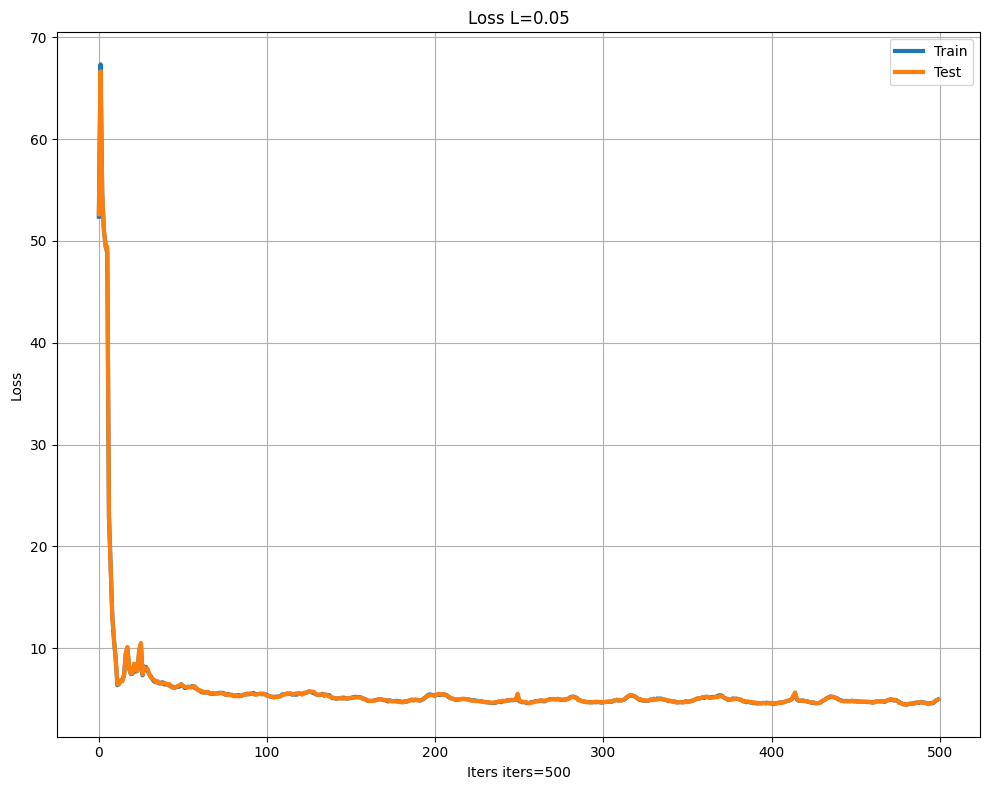

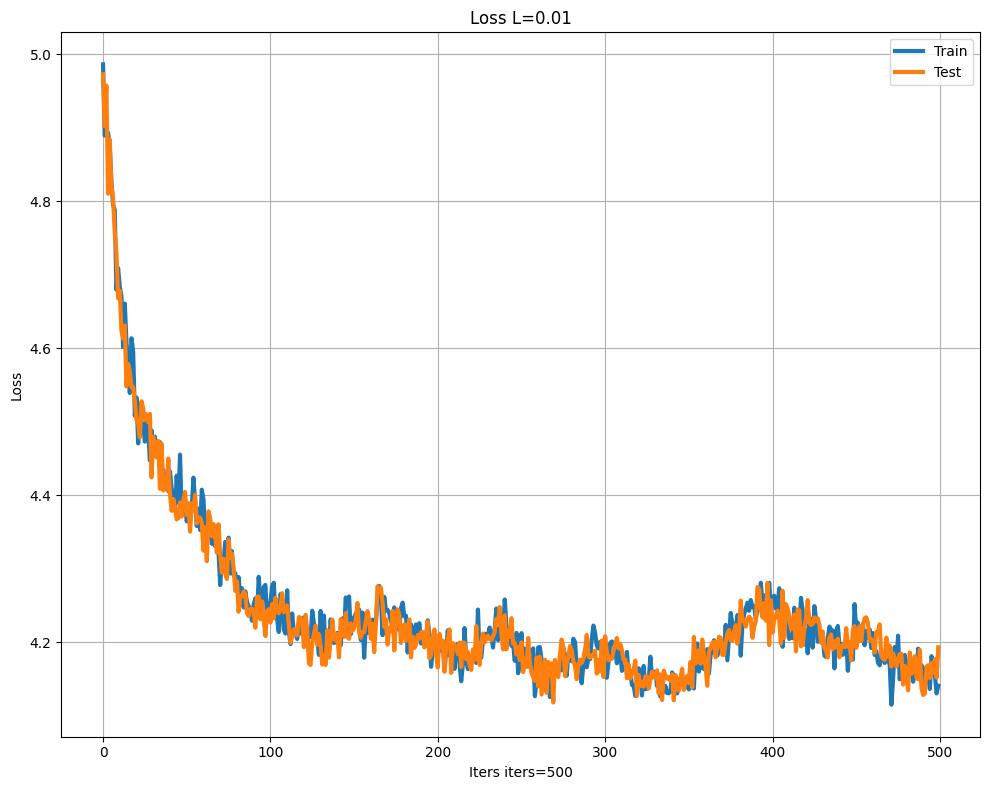

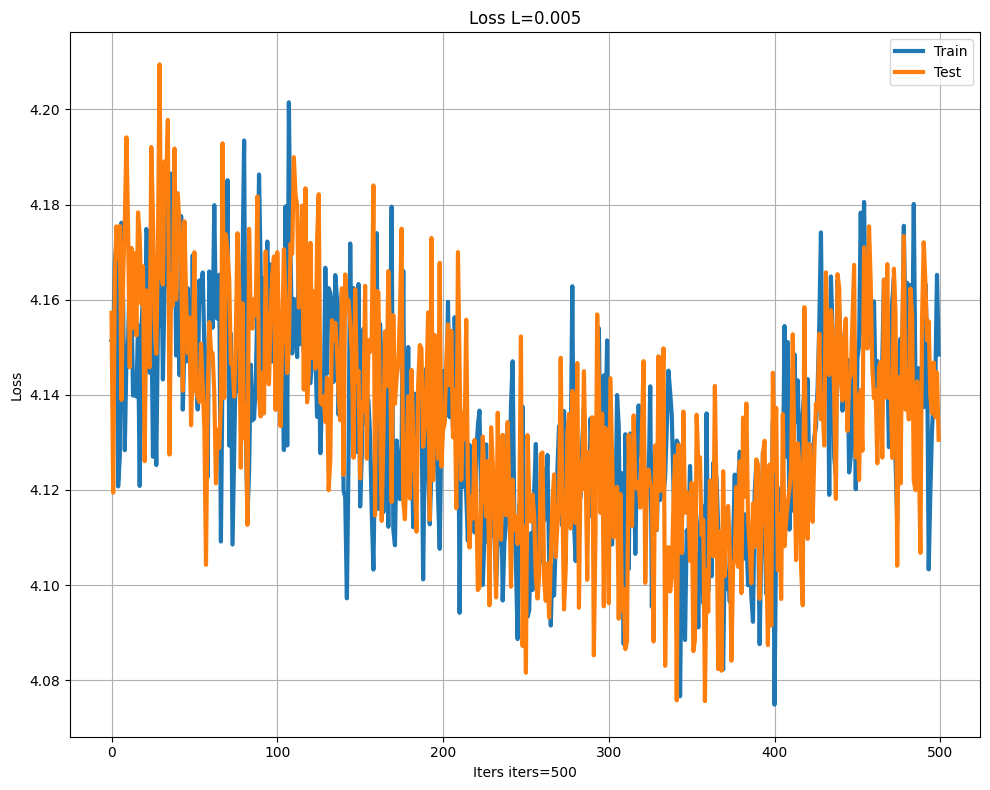

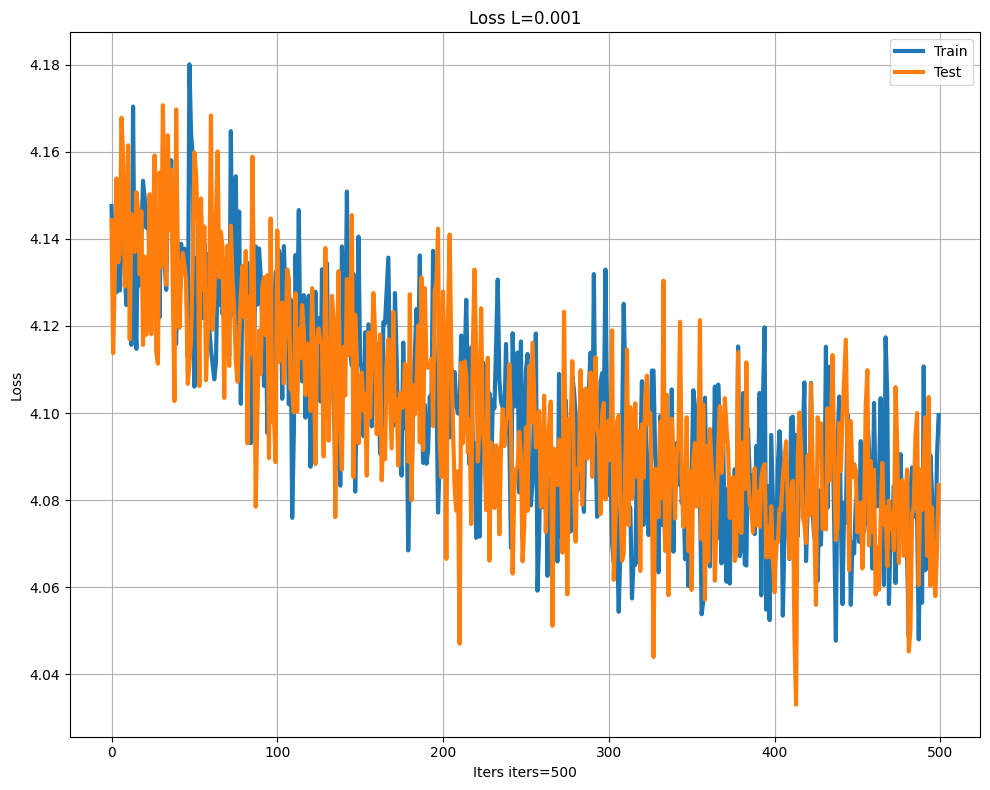

In [ ]:
iter = 500  #, 1_000, 10_000
L_l = [0.05, 0.01, 0.005, 0.001]
momentum = 0.9


w_hidden = np.random.rand(110, 100) * 2 - 1
w_output = np.random.rand(128, 110) * 2 - 1
b_hidden = np.random.rand(110, 1) * 2 - 1
b_output = np.random.rand(128, 1) * 2 - 1

update_w1 = np.zeros(w_hidden.shape)
update_b1 = np.zeros(b_hidden.shape)
update_w2 = np.zeros(w_output.shape)
update_b2 = np.zeros(b_output.shape)

w_h_test, w_o_test, b_h_test, b_o_test = w_hidden, w_output, b_hidden, b_output

for L in L_l:
  w_hidden = w_h_test
  w_output = w_o_test
  b_hidden = b_h_test
  b_output = b_o_test

  update_w1 = np.zeros(w_hidden.shape)
  update_b1 = np.zeros(b_hidden.shape)
  update_w2 = np.zeros(w_output.shape)
  update_b2 = np.zeros(b_output.shape)

  red_neuronal(L=L, epoch=iter, momentum=momentum,
                w_hidden=w_hidden, w_output=w_output,
                b_hidden=b_hidden, b_output=b_output,
                update_w1=update_w1,update_b1=update_b1,
                update_w2=update_w2,update_b2=update_b2)
  print(f'L = {L}')
  print(f'Loss test: {calcular_loss()[0]}')
  print(f'Loss train: {calcular_loss()[1]}')
  print(f'Accuracy Test = {round((calcular_accuracy()[0]/calcular_accuracy()[2]*100),3)}%')
  print(f'Accuracy Train = {round((calcular_accuracy()[1]/calcular_accuracy()[2]*100),3)}%')

      # Calculo la precision y por cada iteracion la guardo para realizar el grafico

Calculo de precision despues del entrenamiento

In [ ]:
print(f'Loss test: {calcular_loss()[0]}')
print(f'Loss train: {calcular_loss()[1]}')
print(f'Accuracy Test = {round((calcular_accuracy()[0]/calcular_accuracy()[2]*100),3)}%')
print(f'Accuracy Train = {round((calcular_accuracy()[1]/calcular_accuracy()[2]*100),3)}%')

Loss test: 4.0886982008238695
Loss train: 4.089264599118215
Accuracy Test = 2.88%
Accuracy Train = 2.96%
